In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.utils import shuffle
from utils import *
from topic_modeling import *
from download_edgar import *
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [2]:
def plot_difference(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='upper')
    plt.title(title)
    plt.colorbar(data)

In [3]:
# Choose an office and sector:
office = 'Trade & Services'
sector = 'Recreational Services'

In [4]:
# Get the training documents from 1 year:
corpus = query_intersection(2010, 2019, office, sector, False)

In [5]:
# Sampling documents in each year for training:
num_years = 2019 - 2010
docs = sampling_corpus(corpus, percent=1/(num_years))

In [6]:
# Covert documents to tokens, bag of word and dictionary format:
texts, bows, dic, bigrams = tokens_bows_dict(docs, 2, 0.5, 2, 80, True)

In [7]:
start = max(len(docs) - 30, 10)
end = len(docs) + 31
step = 10

In [8]:
# Build models for comparison:
models, coherences, perplexities = models_codherence_perplexity(texts, bows, dic,\
        topic_start=start, topic_end=end, step=step, chunk=20, passes=3)

Building model of 10 topics
Building model of 20 topics
Building model of 30 topics
Building model of 40 topics
Building model of 50 topics
Building model of 60 topics


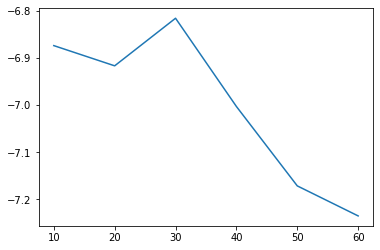

In [9]:
# Plot perplexity vs number of topics:
plt.plot(range(start, end, step), perplexities)

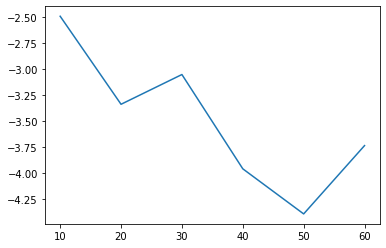

In [10]:
# Plot coherence vs number of topics:
plt.plot(range(start, end, step), coherences)

In [11]:
# Choose a good model:
chosen = models[2]

In [12]:
# Get texts and bows for each year:
texts_vs_year, bows_vs_years = get_texts_bows_vs_years(corpus, dic, bigrams)

In [13]:
# Prepare to get topic union:
topic_list = chosen.show_topics(chosen.num_topics, 10)
top_topics = chosen.top_topics(texts=texts, coherence='c_v', topn=10)

In [14]:
mdiff, annotation = chosen.diff(chosen, distance='jaccard', num_words=100)
# plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

In [15]:
union = topic_union(top_topics, topic_list, mdiff, 10)

In [16]:
hists = topic_hist_years(bows_vs_years, chosen, 0.01, union, mdiff)

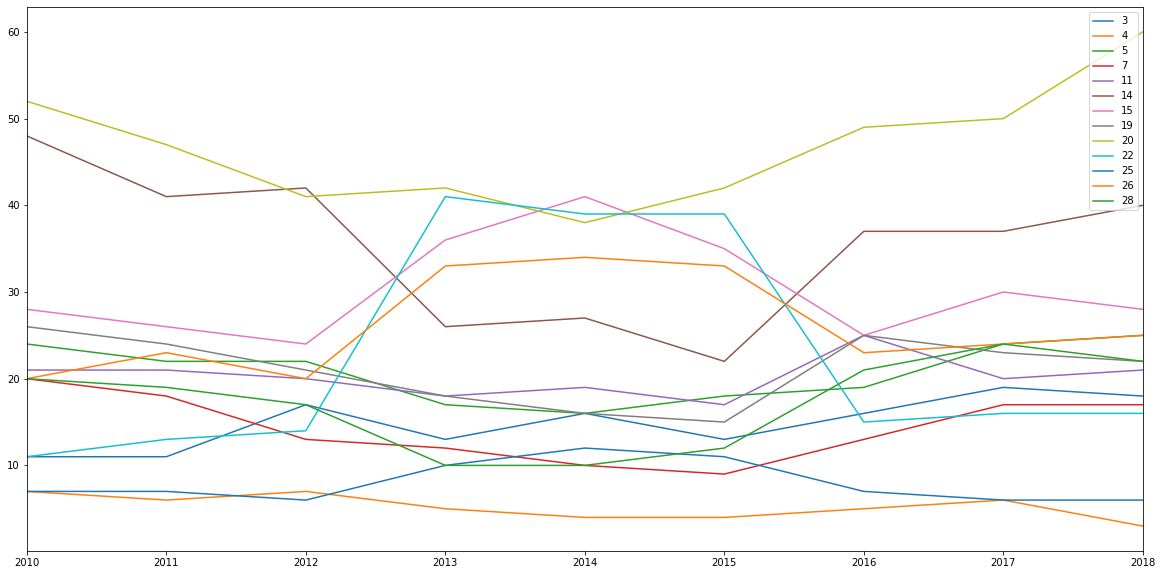

In [17]:
hists = [sorted(hist, key=lambda t: t[0]) for hist in hists]
topic_id = sorted(union)
cac = [[p[1] for p in hist] for hist in hists]
df = pd.DataFrame(cac, columns=topic_id, index=range(2010, 2019))
df.drop(columns=[]).plot(figsize=(20,10), subplots=False, sharey=True)
#df.drop(columns=[]).plot(figsize=(20,100), subplots=True, sharey=False)

In [35]:
pre = {topic_list[i][0]: ' | '.join(re.findall(r'[a-z_]+', topic_list[i][1])) for i in union}
df=df.rename(columns=pre)
df.to_csv(os.getcwd()[:-14] + '/web/source/topicm'+"_"+office+"_"+sector+".csv")